<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Reproduction_of_a_foundational_PINN_method_to_generate_solution_to_1D_Burgers'_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [1]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
from torch import nn

In [2]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

In [3]:
# create dataset
# number of points initial condition and boundary points
Nu = 20

# proportion of Nu which are initial condition points
prop_ic = 0.8
# number of initial condition points
Nu_i = int(prop_ic * Nu)
# number of boundary condition points
Nu_bc = Nu - Nu_i

# number of collocation points across input domain interior
Nf = 2000

In [5]:
# uniformly randomly select some points along the x axis to generate initial condition training points
uniformRandomXArray = rng.uniform(low=xMin, high=xMax, size=Nu_i)

# create array of initial condition defined training points
# t = 0
# x = uniformly random from x domain
# u = -1*sin(pi*x)
Nu_iSet= np.array([
                   np.zeros(Nu_i),
                   uniformRandomXArray,
                   -1 * np.sin(np.pi * uniformRandomXArray)
                    ]).T

In [ ]:
# uniformly randomly select some points along the time axis to generate boundary condition training points
uniformRandomTArray = rng.uniform(low=tMin, high=tMax, size=Nu_bc)

# create array of boundary condition defined training points
# t = uniformly random from time domain
# x = random choice of -1 or 1
# u = 0
Nu_bcSet = np.array([
                        uniformRandomTArray,
                        rng.choice(np.array([-1,1]), size=Nu_bc, replace=True),
                        np.zeros(Nu_bc)
                        ]).T

In [6]:
# define empty array to hold initial and boundary conditions training points
NuTrainingSet = np.zeros((Nu, 3))
# add initial condition points
NuTrainingSet[:Nu_i,:] = Nu_iSet.copy()
# add boundary condition points
NuTrainingSet[Nu_i:,:] = Nu_bcSet.copy()

In [7]:
# shuffle initial and boundary condition training points
rng.shuffle(NuTrainingSet)
# convert numpy array to pytorch tensor
NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
# split into input and outputs for training
# set input tensor to store calculated gradients
NuX = NuSetTensor[:,:2].requires_grad_()
Nuy = NuSetTensor[:,2]

In [8]:
# create collocation training points selected uniformly randomly across input domain
NfSet = np.array([
               rng.uniform(tMin, tMax, Nf),
               rng.uniform(xMin, xMax, Nf),
               ]).T

# convert numpy array to pytorch tensor and set to store calculated gradients
NfTensor = torch.from_numpy(NfSet.astype(np.float32)).requires_grad_()

In [20]:
# define neural network architecture

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()        
        self.linear_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),         
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 1),
        )            

    def forward(self, inputs):
        u = self.linear_stack(inputs)
        return u

In [23]:
model = NeuralNetwork()

In [22]:
NfTensor.shape

torch.Size([2000, 2])

In [24]:
u = model(NfTensor)


In [26]:
# compute first derivatives of solution with respect to inputs (t, x)
firstDerivatives = torch.autograd.grad(u, NfTensor, torch.ones_like(u), create_graph=True)[0]

In [29]:
# firstDerivatives[:10,:]
firstDerivatives.shape

torch.Size([2000, 2])

In [31]:
# compute second derivatives
secondDerivatives = torch.autograd.grad(firstDerivatives, NfTensor,  retain_graph=True)[0] #torch.ones_like(firstDerivatives),

RuntimeError: ignored

In [30]:
secondDerivatives.shape

torch.Size([2000, 2])

In [10]:
# function to compute residual
# input: d x 2 dimensional tensor containing d (t, x) value pairs from input domain
# output: d x 1 dimensional tensor containing computed residual for 1D Burgers' equation
def residual(pointsArray_tx, viscosity=(0.01/np.pi)):
    # compute neural network solution approximations
    u = model(pointsArray_tx)
    # compute first derivatives of solution with respect to inputs (t, x)
    firstDerivatives = torch.autograd.grad(u, pointsArray_tx, torch.ones_like(u), create_graph=True)[0]
    # compute second derivatives
    secondDerivatives = torch.autograd.grad(firstDerivatives, pointsArray_tx, torch.ones_like(firstDerivatives), retain_graph=True)[0]

    if len(list(pointsArray_tx.size())) > 1:
        ut = firstDerivatives[:,0] 
        ux = firstDerivatives[:,1]
        uxx = secondDerivatives[:,1]
    
    else:
        ut = firstDerivatives[0] 
        ux = firstDerivatives[1]
        uxx = secondDerivatives[1]

    return ut.flatten() + u.flatten() * ux.flatten() - viscosity * uxx.flatten()

In [11]:
def meshPlot(xDim, yDim):

    #NfTensor = torch.from_numpy(NfSet.astype(np.float32)).requires_grad_()

    x = np.arange(tMin, tMax, (tMax-tMin)/xDim)
    y = np.arange(xMin, xMax, (xMax-xMin)/yDim)
    X,Y = np.meshgrid(x, y)

    flattenedCoords = np.zeros((xDim*yDim, 2))
    flattenedCoords[:,0] = X.flatten()
    flattenedCoords[:,1] = Y.flatten()

    flattenedCoords = torch.from_numpy(flattenedCoords.astype(np.float32))

    

    flattenedU = model(flattenedCoords)
    U = torch.reshape(flattenedU, (yDim, xDim)).detach().numpy()

    flattenedCoords = flattenedCoords.requires_grad_()

    # print(flattenedCoords[-5:])
    
    flattenedResidual_err = residual(flattenedCoords)

    # print('here')
    residual_err = torch.reshape(flattenedResidual_err, (yDim, xDim)).detach().numpy()
    
    # surf1 = ax.plot_surface(X, Y, U, cmap=mycmap)
    # fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5)

    return X, Y, U, residual_err

    

Parameters: 1761


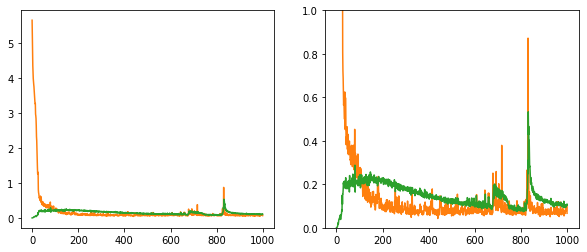

In [12]:
model = NeuralNetwork()
print(f'Parameters: {sum(p.numel() for p in model.parameters())}')
# print(model)

MSEfunc = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())
# optimiser = torch.optim.LBFGS(model.parameters(), lr=1)

epochs = 1000

totalLoss = []
uLoss = []
fLoss = []

uBatchSize = 1
fBatchSize = 2000

model.train()
for epoch in range(epochs):


    fLossEpoch = 0
    
    
    for i in range(NfTensor.shape[0]//fBatchSize):
        optimiser.zero_grad()
        
        MSEf = MSEfunc(residual(NfTensor[i*fBatchSize:(i+1)*fBatchSize]), torch.zeros(fBatchSize)) #  #torch.zeros(fBatchSize) #torch.tensor([0.])

        fLossEpoch += MSEf.item()

        MSEf.backward()
        optimiser.step()
    
    
    fLoss.append(fLossEpoch)

    uLossEpoch = 0
    
    rng.shuffle(NuTrainingSet)
    NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
    NuX = NuSetTensor[:,:2].requires_grad_()
    Nuy = NuSetTensor[:,2]

    for i in range(NuX.shape[0]//uBatchSize):
        optimiser.zero_grad()

        MSEu = MSEfunc(model(NuX[i*uBatchSize:(i+1)*uBatchSize]), torch.reshape(Nuy[i*uBatchSize:(i+1)*uBatchSize], (uBatchSize,1)))

        uLossEpoch += MSEu.item()
        
        MSEu.backward()

        optimiser.step()
    
    uLoss.append(uLossEpoch)

    

    # loss = MSEu + MSEf 
    # totalLoss.append(loss.item()) 
    
    # optimiser.step(closure)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(totalLoss)
axs[0].plot(uLoss)
axs[0].plot(fLoss)

axs[1].plot(totalLoss)
axs[1].plot(uLoss)
axs[1].plot(fLoss)
axs[1].set_ylim([0, 1])

# with torch.no_grad():
model.eval()
X, Y, U, res = meshPlot(1000, 1000) 

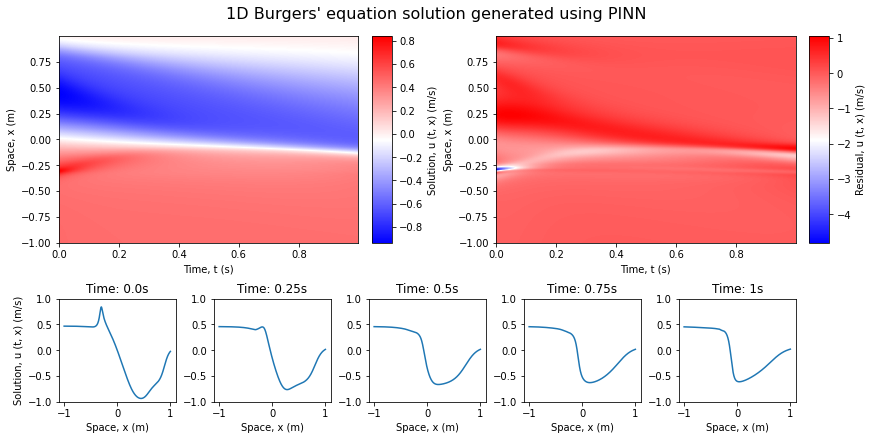

In [19]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(X, Y, U, cmap='bwr')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
residualPlot = residualAx.pcolormesh(X, Y, res, cmap='bwr')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(Y[:, i*(Y.shape[1]//4)], U[:, i*(Y.shape[1]//4)])
        tPlot.set_title('Time: ' + str(i*X[0, X[0].shape[0]//4]) + 's')
    else:
        tPlot.plot(Y[:, -1], U[:, -1])
        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

# figure title
fig.suptitle("1D Burgers' equation solution generated using PINN", fontsize=16)

# fig.savefig("1D Burgers' - PINN", bbox_inches='tight')
plt.show()